In [1]:


import numpy.linalg as LA
import matplotlib.pyplot as plt
from my_pickle import my_pickle_load, my_pickle_dump

%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [19]:
import cPickle as pickle
import pandas as pd
import numpy as np
from textblob import TextBlob

#from bs4 import BeautifulSoup
#from sklearn.naive_bayes import MultinomialNB

import string
import math
#import glob
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import tokenize
from nltk.stem.porter import *
from nltk.corpus import stopwords

from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim.models.lsimodel import LsiModel

from gensim import corpora, models, similarities
from sklearn.metrics.pairwise import linear_kernel
import tldextract

In [5]:
df = pd.read_csv('../data/nutch-crawl-huizhou-domain_only2-02-15-2017.csv')

In [16]:
df.head()

,id,content,title,_version_,cache,segment,digest,boost,tstamp,url,doc_len,bucket
0,http://cul.anhuinews.com/system/2009/03/05/002...,"第十六章(2)-月上重火,连载,阅读-中安在线-徽文化 首页 新闻 安徽 网视 ...","第十六章(2)-月上重火,连载,阅读-中安在线-徽文化",1559246026098868224,NaN,20170213160703,306a2bbf507dca8af08ca26bdc835949,0.001681,2017-02-13T17:25:31.777Z,http://cul.anhuinews.com/system/2009/03/05/002...,6962,"(5688.65, 7443.2]"
1,http://cul.anhuinews.com/system/2009/03/05/002...,"第十六章(1)-月上重火,连载,阅读-中安在线-徽文化 首页 新闻 安徽 网视 ...","第十六章(1)-月上重火,连载,阅读-中安在线-徽文化",1559246026107256832,NaN,20170213160703,38d30b20526082bbcdfc2d911528da3a,0.001665,2017-02-13T17:47:03.783Z,http://cul.anhuinews.com/system/2009/03/05/002...,10307,"(9197.75, 10952.3]"
2,http://cul.anhuinews.com/system/2009/03/05/002...,"第十五章(4)-月上重火,连载,阅读-中安在线-徽文化 首页 新闻 安徽 网视 ...","第十五章(4)-月上重火,连载,阅读-中安在线-徽文化",1559246026110402560,NaN,20170213160703,c80267d57e6a8c6eecb593b2617e438c,0.001650,2017-02-13T16:20:40.982Z,http://cul.anhuinews.com/system/2009/03/05/002...,3698,"(2179.55, 3934.1]"
3,http://cul.anhuinews.com/system/2009/03/05/002...,"第十五章(3)-月上重火,连载,阅读-中安在线-徽文化 首页 新闻 安徽 网视 ...","第十五章(3)-月上重火,连载,阅读-中安在线-徽文化",1559246026111451136,NaN,20170213160703,31ea7eaa5e81e56ed3fc2a54e3978530,0.001650,2017-02-13T18:57:11.49Z,http://cul.anhuinews.com/system/2009/03/05/002...,6943,"(5688.65, 7443.2]"
4,http://cul.anhuinews.com/system/2009/03/05/002...,"第十五章(2)-月上重火,连载,阅读-中安在线-徽文化 首页 新闻 安徽 网视 ...","第十五章(2)-月上重火,连载,阅读-中安在线-徽文化",1559246026117742592,NaN,20170213160703,a22abfd3a1ed3d6065f9fb3ec2502e3f,0.001634,2017-02-13T16:40:17.225Z,http://cul.anhuinews.com/system/2009/03/05/002...,7078,"(5688.65, 7443.2]"


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25291 entries, 0 to 25290
Data columns (total 10 columns):
id           25291 non-null object
content      23145 non-null object
title        23145 non-null object
_version_    25291 non-null int64
cache        4 non-null object
segment      25291 non-null int64
digest       25291 non-null object
boost        25291 non-null float64
tstamp       25291 non-null object
url          25291 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 2.1+ MB


In [20]:
def map_domain(x):
    tldextract.extract(df.loc[i]['url']).domain + str('.') + tldextract.extract(df.loc[i]['url']).suffix

In [21]:
#df['host'] = df.url.map(lambda x: x.split('://')[1].split('/')[0] )  
df['domain']  = df.url.map(lambda x:tldextract.extract(x).domain + str('.') + tldextract.extract(x).suffix)

In [32]:
count = Counter(df['domain'])

In [33]:
print count

Counter({'ahage.net': 15827, 'anhuinews.com': 6037, '99huizhou.com': 3422, '517huizhou.com': 5})


In [30]:
t = df[df['domain'] == ''].count()

In [31]:
print t

25291


In [7]:
df['doc_len'] = df['content'].str.len()

In [8]:
df['doc_len'].max()

70607.0

In [9]:
df_2000 = df[df['doc_len'] < 2000]

In [10]:
df['bucket'] = pd.cut(df.doc_len, 40)

In [11]:
newdf = df[['bucket','doc_len']].groupby('bucket').count()

In [12]:
newdf.head(100)

,doc_len
bucket,
"(354.818, 2179.55]",1140
"(2179.55, 3934.1]",6067
"(3934.1, 5688.65]",6596
"(5688.65, 7443.2]",5125
"(7443.2, 9197.75]",2972
"(9197.75, 10952.3]",631
"(10952.3, 12706.85]",250
"(12706.85, 14461.4]",97
"(14461.4, 16215.95]",73


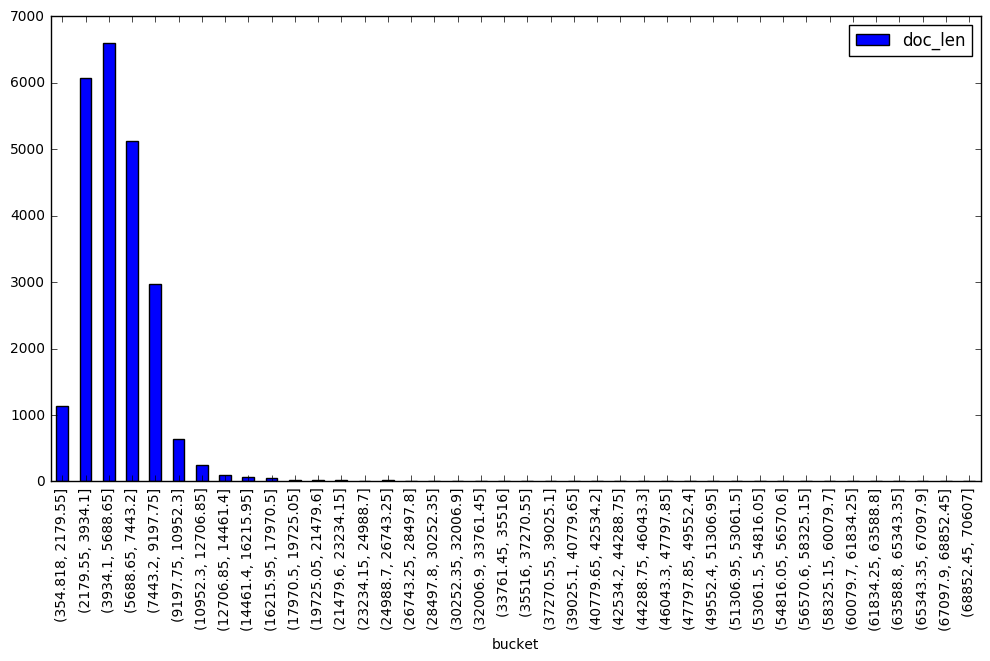

In [13]:
newdf.plot(kind='bar', figsize=(12, 6))

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


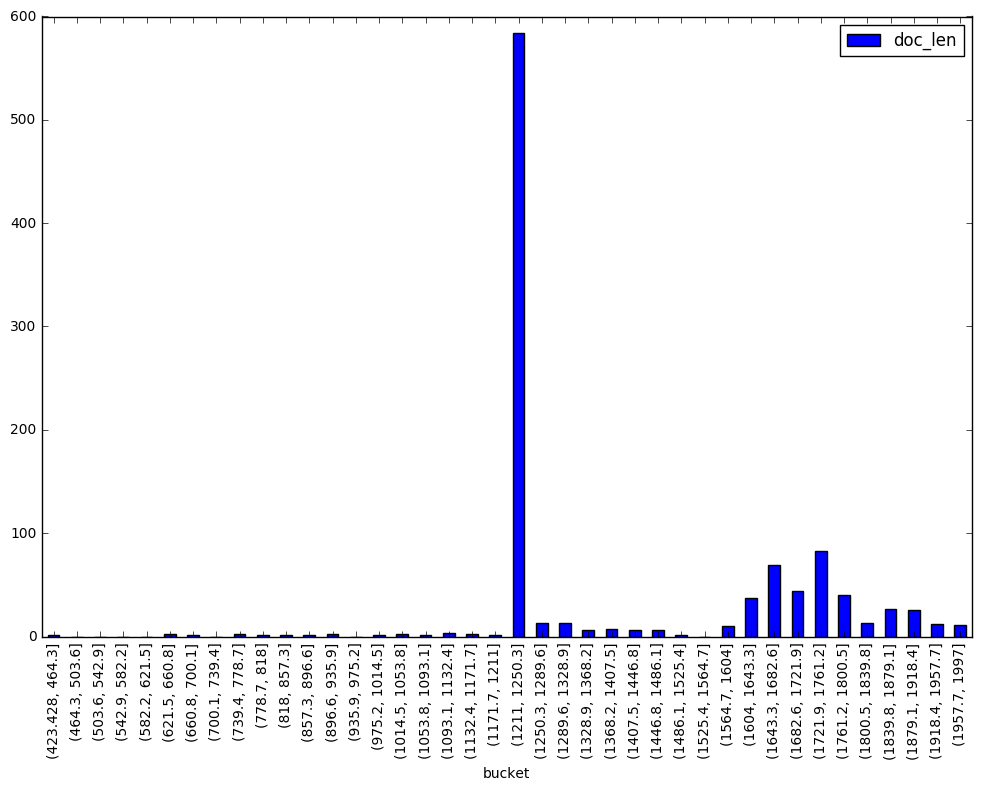

In [14]:
df_2000['bucket'] = pd.cut(df_2000.doc_len, 40)
newdf_2000 = df_2000[['bucket','doc_len']].groupby('bucket').count()
newdf_2000.plot(kind='bar', figsize=(12, 8))

In [15]:
df_50 = df[df['doc_len'] < 50]
df_50['bucket'] = pd.cut(df_50.doc_len, 40)
newdf_50 = df_50[['bucket','doc_len']].groupby('bucket').count()
newdf_50.plot(kind='bar', figsize=(12, 8))

ValueError: Cannot cut empty array

In [16]:
df_dropped = df[df['doc_len'] > 100]

In [17]:
df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61809 entries, 0 to 62060
Data columns (total 9 columns):
id         61809 non-null object
tstamp     61809 non-null object
url        61809 non-null object
domain     61809 non-null object
title      61638 non-null object
digest     61809 non-null object
content    61809 non-null object
doc_len    61809 non-null int64
bucket     61809 non-null category
dtypes: category(1), int64(1), object(7)
memory usage: 4.3+ MB


In [18]:
df_final = df_dropped[['tstamp', 'domain', 'url', 'content', 'title', 'doc_len']]

In [19]:
df_final.head()

,tstamp,domain,url,content,title,doc_len
0,2017-01-15T16:23:45.703Z,99huizhou.com,http://www.99huizhou.com/thread-102832-1-1.html,【视频】白岳笔会之座谈会-白岳笔会-故园徽州网 - Powered by Discuz! 故...,【视频】白岳笔会之座谈会-白岳笔会-故园徽州网 - Powered by Discuz!,3936
1,2017-01-15T16:32:56.699Z,99huizhou.com,http://www.99huizhou.com/thread-102832-3-1.html,【视频】白岳笔会之座谈会-白岳笔会-故园徽州网 - Powered by Discuz! 故...,【视频】白岳笔会之座谈会-白岳笔会-故园徽州网 - Powered by Discuz!,4721
2,2017-01-15T17:09:56.419Z,99huizhou.com,http://www.99huizhou.com/thread-108113-1-1.html,这个怎么用？ - 徽州摄影旅游群 - 故园徽州 - Powered by Discuz! 故...,这个怎么用？ - 徽州摄影旅游群 - 故园徽州 - Powered by Discuz!,3585
3,2017-01-15T19:00:55.159Z,99huizhou.com,http://www.99huizhou.com/thread-110501-1-1.html,黄山日报：石潭摄影基地建设快速推进 - 徽州摄影旅游群 - 故园徽州 - Powered b...,黄山日报：石潭摄影基地建设快速推进 - 徽州摄影旅游群 - 故园徽州 - Powered b...,6176
4,2017-01-15T16:19:47.112Z,99huizhou.com,http://www.99huizhou.com/thread-117056-1-1.html,故园徽州9月9日签到记录贴-说鳖茶馆-故园徽州网 - Powered by Discuz! ...,故园徽州9月9日签到记录贴-说鳖茶馆-故园徽州网 - Powered by Discuz!,4597


In [20]:
articles = df_final['content']

In [21]:
titles = df_final['title']

In [22]:
articles.shape

(61809,)

In [23]:
#articles_2000 = articles[:2000]

In [24]:
#articles_2000.shape

In [25]:
def get_tokens(doc):
    lowers = doc.lower()
    #no_punctuation = lowers.translate(None, string.punctuation)

    #remove the punctuation using the character deletion step of translate
    no_punctuation = lowers.translate(None, string.punctuation)
    no_punctuation_decode = no_punctuation.decode('ascii', errors='ignore')

    tokens = nltk.word_tokenize(no_punctuation_decode)
    
    filtered = [w for w in tokens if not w in stopwords.words('english') and len(w) > 1]
    
    #tokens_no_stopwords = [token for token in tokens if token not in stopwords.word('english')] 
    #return tokens_no_stopwords
    
#    print (len(filtered))
    
    return filtered

In [26]:
tot_tokens = [get_tokens(article) for article in articles]
print len(tot_tokens)

61809


In [28]:
my_pickle_dump('solr_tot_tokens.pkl', tot_tokens)

In [29]:
flatten = [ inner for sublist in tot_tokens for inner in sublist ]

In [30]:
my_pickle_dump('solr_tot_flatten.pkl', flatten)

In [30]:
# with open('solr_flatten.txt', 'w') as f:
#     f.write(str(flatten))

In [31]:
# flatten_ascii = flatten.encode('ascii', igore)

In [3]:
flatten = my_pickle_load('solr_tot_flatten.pkl')

In [31]:
count = Counter(flatten)

In [32]:
most_common_words = count.most_common(50)
print most_common_words

[(u'10', 33393), (u'1208228', 31707), (u'b220080023', 30086), (u'2016', 26701), (u'100', 23020), (u'24', 17858), (u'2017', 16507), (u'copyright', 16494), (u'div', 16387), (u'11', 14294), (u'dedecms', 14165), (u'12', 11846), (u'qq', 11201), (u'rights', 10358), (u'span', 10203), (u'20', 10148), (u'reserved', 10141), (u'2015', 9852), (u'30', 9219), (u'li', 8713), (u'15', 8308), (u'tag', 7899), (u'anhui', 7627), (u'16', 7476), (u'03', 7410), (u'20092010', 7230), (u'50', 7215), (u'1217188019', 7119), (u'13', 6702), (u'power', 6687), (u'20022011', 6574), (u'powered', 5900), (u'14', 5528), (u'01', 5451), (u'05', 5426), (u'21', 5380), (u'08', 5358), (u'02', 5321), (u'18', 5239), (u'09', 5231), (u'nba', 5227), (u'90', 5178), (u'dvd', 5074), (u'04', 5051), (u'06', 5003), (u'07', 5000), (u'25', 4972), (u'discuz', 4872), (u'17', 4804), (u'20170113', 4579)]


In [33]:
words, counts = zip(*most_common_words)

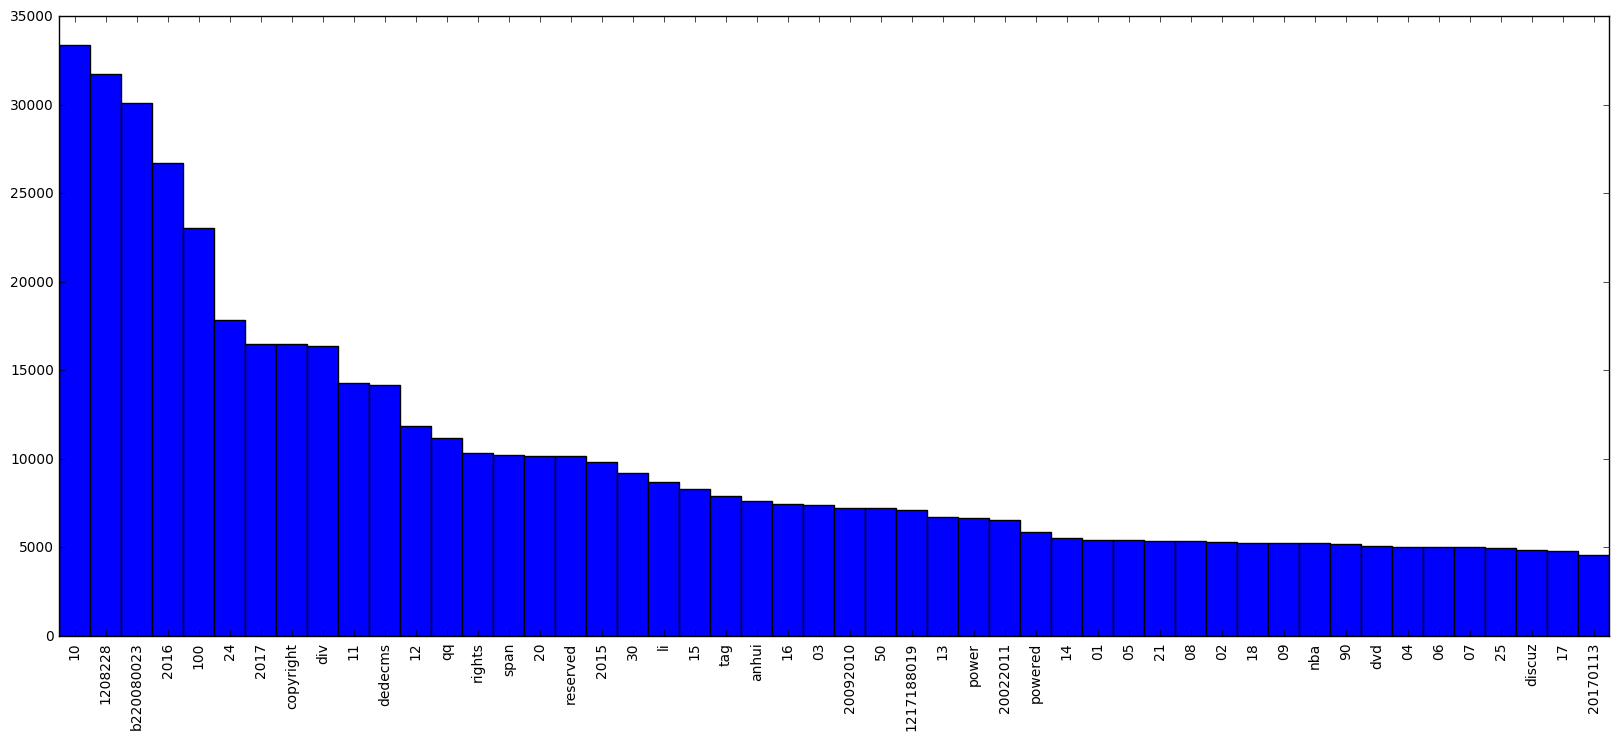

In [34]:
pos = np.arange(len(words))
width = 1.0     # gives histogram aspect to the bar diagram

plt.figure(figsize=(20,8))

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(words, rotation=90)

plt.bar(pos, counts, width, color='b')
plt.show()

In [35]:

#Create your bigrams
bgs = nltk.bigrams(flatten)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(bgs)

# for k,v in fdist.items():
#     print k,v

In [36]:
fds = fdist.most_common(50)
print fds

[((u'b220080023', u'1208228'), 28559), ((u'rights', u'reserved'), 10058), ((u'1208228', u'20092010'), 7199), ((u'20022011', u'dedecms'), 6572), ((u'copyright', u'20022011'), 6572), ((u'power', u'dedecms'), 6571), ((u'dedecms', u'power'), 6571), ((u'tag', u'copyright'), 6571), ((u'div', u'div'), 5554), ((u'10', u'b220080023'), 4410), ((u'powered', u'discuz'), 4179), ((u'1217188019', u'tag'), 4081), ((u'anhui', u'dvd'), 3848), ((u'occurred', u'processing'), 3832), ((u'processing', u'directive'), 3832), ((u'error', u'occurred'), 3832), ((u'alt', u'h2h2'), 3816), ((u'li', u'li'), 3784), ((u'2016', u'2016'), 3780), ((u'24', u'b220080023'), 3417), ((u'2016', u'24'), 3252), ((u'directive', u'error'), 2788), ((u'100', u'10'), 2777), ((u'100', u'1217188019'), 2765), ((u'10', u'11'), 2747), ((u'20161112', u'2016'), 2695), ((u'icp08007183', u'1208228'), 2568), ((u'2017', u'2017'), 2393), ((u'qq', u'qq'), 2384), ((u'reserved', u'b220080023'), 2321), ((u'010203040506', u'03'), 2252), ((u'h2h2', u'p

In [37]:
words, counts = zip(*fds)
words_zip = [' '.join(word) for word in words]

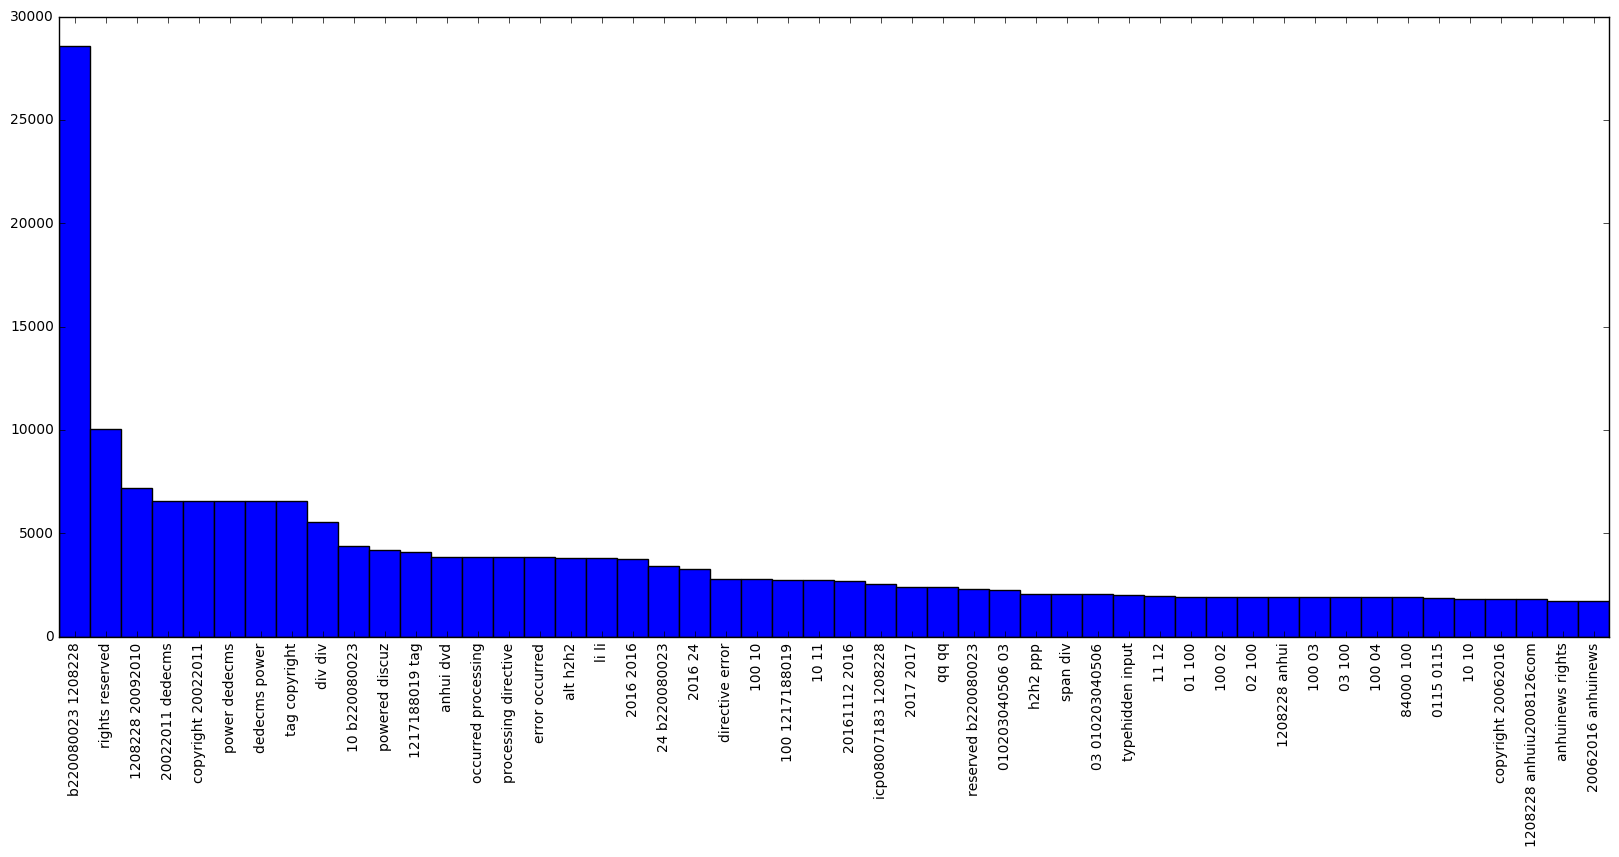

In [38]:
pos = np.arange(len(words_zip))
width = 1.0     # gives histogram aspect to the bar diagram

plt.figure(figsize=(20,8))

ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(words_zip, rotation=90)

plt.bar(pos, counts, width, color='b')
plt.show()

In [39]:
#txt = '\xc2\xa0 this is a test'

In [40]:
#txt.decode('ascii', errors='ignore')

In [41]:
def tokenize_and_normalize(chunks):
#     print 'doc size', len(chunks)
    chunks_dec = chunks.decode('ascii', errors='ignore')
    words = [ tokenize.word_tokenize(sent) for sent in tokenize.sent_tokenize(chunks_dec) ]
    flatten = [ inner for sublist in words for inner in sublist ]
    stripped = [] 

    for word in flatten:         
        if word not in stopwords.words('english'):
            try:
                stripped.append(word.encode('latin-1').decode('utf8').lower())
            except:
                print "Cannot encode: " + word
                pass
    
    s = [ word for word in stripped if len(word) > 1 ] 
    
#     print 'word size', len(s)   
#     print s
    
    return s

In [42]:
#parsed = [ tokenize_and_normalize(s) for s in articles]

In [43]:
#my_pickle_dump('solr_parsed.pkl', parsed)

In [44]:
#tot_tokens = my_pickle_load('solr_tot_tokens.pkl')

In [45]:
dictionary = corpora.Dictionary(tot_tokens)


In [46]:
my_pickle_dump('solr_dictionary.pkl', dictionary)

In [47]:
corpus = [dictionary.doc2bow(text) for text in tot_tokens]

In [48]:
my_pickle_dump('solr_corpus.pkl', corpus)

In [49]:
#corpus1 = my_pickle_load('solr_corpus.pkl')

In [50]:
tfidf = models.TfidfModel(corpus)

In [52]:
corpus_tfidf = tfidf[corpus]

In [59]:
print type(corpus_tfidf)

<class 'gensim.interfaces.TransformedCorpus'>


In [54]:
corpus_np = np.array(corpus)

In [55]:
corpus_np.shape

(61809,)

In [57]:
corpus[12]

[(0, 6),
 (3, 1),
 (8, 1),
 (9, 1),
 (11, 2),
 (12, 1),
 (16, 1),
 (17, 1),
 (19, 3),
 (21, 1),
 (30, 1),
 (41, 1),
 (42, 1),
 (44, 1),
 (45, 1),
 (47, 2),
 (48, 6),
 (54, 1),
 (57, 1),
 (59, 1),
 (60, 2),
 (64, 1),
 (65, 1),
 (87, 1),
 (140, 1),
 (168, 2),
 (189, 2),
 (228, 2),
 (317, 1),
 (318, 1),
 (319, 1),
 (320, 1),
 (321, 1),
 (322, 1),
 (323, 1),
 (324, 3),
 (325, 1),
 (326, 3),
 (327, 1),
 (328, 1),
 (329, 5),
 (330, 1),
 (331, 1),
 (332, 1),
 (333, 2),
 (334, 1),
 (335, 1),
 (336, 1),
 (337, 1),
 (338, 1),
 (339, 2),
 (340, 1)]

In [58]:
my_pickle_dump('solr_corpus_tfidf.pkl', corpus_tfidf)

In [62]:
corpus_tfidf = my_pickle_load('solr_corpus_tfidf.pkl')


In [59]:
dictionary = my_pickle_load('solr_dictionary.pkl')

In [60]:
model = LsiModel(corpus_tfidf, id2word=dictionary, num_topics=300)

In [61]:
model.show_topic(10, topn=5)

[(u'directive', 0.47047995879164139),
 (u'occurred', 0.46924078497926441),
 (u'error', 0.4675630748359425),
 (u'processing', 0.46425408904026805),
 (u'cctv4', -0.20302559437613801)]

In [62]:
model.show_topics()

[(0,
  u'0.624*"dedecms" + 0.319*"1217188019" + 0.315*"20022011" + 0.313*"power" + 0.313*"tag" + 0.221*"100" + 0.219*"copyright" + 0.077*"2015" + 0.073*"10" + 0.057*"11"'),
 (1,
  u'0.346*"discuz" + 0.332*"qq" + 0.326*"powered" + 0.197*"icp09029325" + 0.197*"34100202000037" + 0.196*"qr" + 0.195*"comsenz" + 0.194*"x32" + 0.193*"20012013" + 0.186*"code"'),
 (2,
  u'-0.255*"03" + -0.247*"100" + -0.228*"01" + -0.227*"02" + -0.222*"04" + -0.221*"06" + -0.220*"2016" + -0.218*"07" + -0.212*"08" + -0.211*"05"'),
 (3,
  u'0.357*"2016" + 0.225*"2017" + -0.219*"100" + -0.206*"03" + -0.193*"01" + -0.193*"02" + -0.190*"04" + -0.189*"06" + -0.187*"07" + -0.178*"09"'),
 (4,
  u'-0.777*"div" + -0.496*"span" + -0.211*"input" + -0.176*"typehidden" + -0.071*"hrefjavascriptvoid0" + -0.035*"foreach" + -0.035*"typetext" + -0.035*"styledisplaynone" + -0.035*"classmsgfunc" + -0.035*"namevochannelid"'),
 (5,
  u'-0.355*"20072010" + -0.354*"icp070115451" + -0.354*"ahwhnet" + -0.350*"ahagenet" + -0.339*"qq785304

In [72]:
my_pickle_dump('solr_lsimodel.pkl', model)

In [49]:
lda=LdaModel(corpus_tfidf, id2word=dictionary, num_topics=15, update_every=0, passes=200)

In [50]:
my_pickle_dump('solr_lda.pkl', lda)

In [4]:
lda2 =my_pickle_load('solr_lda.pkl')

In [5]:
lda2.print_topics(15, 15)

[(0,
  u'0.001*dmu + 0.000*lindner + 0.000*genexprotools + 0.000*equilibrium + 0.000*buscar + 0.000*para + 0.000*de + 0.000*geoda + 0.000*montfort + 0.000*compartir + 0.000*correo + 0.000*gusta + 0.000*iniciar + 0.000*jquery + 0.000*adma'),
 (1,
  u'0.001*di + 0.001*orleans + 0.001*wppostimage + 0.001*nolacom + 0.000*classattachmentthumbnail + 0.000*timespicayune + 0.000*width150 + 0.000*classfield + 0.000*classfielditem + 0.000*classfielditemsdiv + 0.000*stylefloat + 0.000*5px + 0.000*img + 0.000*fieldlabelhiddendiv + 0.000*marginleft'),
 (2,
  u'0.003*data + 0.002*analytics + 0.002*big + 0.001*science + 0.001*2015 + 0.001*business + 0.001*management + 0.001*blog + 0.001*services + 0.001*news + 0.001*cloud + 0.001*information + 0.001*research + 0.001*2016 + 0.001*university'),
 (3,
  u'0.011*thinkers + 0.008*worlds + 0.005*best + 0.004*analytics + 0.004*social + 0.003*workforce + 0.003*data + 0.003*media + 0.002*cloud + 0.002*smartdata + 0.002*management + 0.002*followers + 0.002*coll

In [19]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [35]:

articles1 = articles[:2000]
titles1=titles[:2000]

In [36]:
queries = ['data science\n', 'machine learning\n', 'python\n', 'deep learning\n']

# DO TFIDF TRANSFORMATION
vectorizer = TfidfVectorizer(stop_words='english')

vectors = vectorizer.fit_transform(articles1).toarray()



In [37]:
my_pickle_dump('solr_vectorizer.pkl', vectorizer)
my_pickle_dump('solr_vectors.pkl', vectors)

In [38]:
def top_n(vectorizer, vectors, data, n):
    '''
    Print out the top 10 words by three different sorting mechanisms:
        * average tf-idf score
        * total tf-idf score
        * highest TF score across corpus
    '''
    words = vectorizer.get_feature_names()

    # Top 10 words by average tfidf
    # Take the average of each column, denoted by axis=0
    avg = np.sum(vectors, axis=0) / np.sum(vectors > 0, axis=0)
    print "top %d by average tf-idf" % n
    print get_top_values(avg, n, words)
    print

    # Top 10 words by total tfidf
    total = np.sum(vectors, axis=0)
    print "top %d by total tf-idf" % n
    print get_top_values(total, n, words)
    print

    # Top 10 words by TF
    vectorizer2 = TfidfVectorizer(use_idf=False)
    # make documents into one giant document for this purpose
    vectors2 = vectorizer2.fit_transform([" ".join(data)]).toarray()
    print "top %d by tf across all corpus" % n
    print get_top_values(vectors2[0], n, words)
    print

def get_top_values(lst, n, labels):
    '''
    INPUT: LIST, INTEGER, LIST
    OUTPUT: LIST

    Given a list of values, find the indices with the highest n values. Return
    the labels for each of these indices.

    e.g.
    lst = [7, 3, 2, 4, 1]
    n = 2
    labels = ["cat", "dog", "mouse", "pig", "rabbit"]
    output: ["cat", "pig"]
    ''' 

#     print "get_top_values", len(lst), n, len(labels)
    
#     seqs =  np.argsort(lst)[-1:-n-1:-1] 
#     for k in seqs:
#         print k, labels[k]

#    print 'before return 0000', len(seqs)
        
    ret = [labels[i] for i in np.argsort(lst)[-1:-n-1:-1]]

#    print 'before return', len(ret)
#     return [labels[i] for i in np.argsort(lst)[-1:-n-1:-1]]
    return ret

def ranking(vectorizer, vectors, titles, queries, n):
    '''
    Print out the top n documents for each of the queries.
    '''
#    print queries
    
    tokenized_queries = vectorizer.transform(queries)
    cosine_similarities = linear_kernel(tokenized_queries, vectors)
    
#    print 'cosine', cosine_similarities
    
    for i, query in enumerate(queries):
        print query
        ret = get_top_values(cosine_similarities[i], 3, titles)
        
        #print "ret len ---", len(ret)
        
        for k in xrange(n):
            print k, ret[k]
#        print get_top_values(cosine_similarities[i], 3, titles)
        print




In [39]:

# FEATURE IMPORTANCES
top_n(vectorizer, vectors, articles1, 10)

# RANKING
#ranking(vectorizer, vectors, pure_docs, get_queries('queries.txt'), 3)
ranking(vectorizer, vectors, titles, queries, 3)


top 10 by average tf-idf
[u'idiro', u'knewton', u'manta', u'cronkite', u'xs', u'iioa', u'zocdoc', u'niara', u'keylines', u'param']

top 10 by total tf-idf
[u'data', u'business', u'2015', u'analytics', u'big', u'management', u'bi', u'new', u'london', u'2014']

top 10 by tf across all corpus
[u'ti', u'andreessen', u'toying', u'oncologists', u'incumbents', u'datainnovation', u'formidables', u'itrem', u'thurrock', u'oprah']

data science

0 Revolutions: profiles
1 Revolutions: random
2 Difference between data engineers and data scientists - Data Science Central

machine learning

0 SIGKDD Innovation Award | Sig KDD
1 Zeller-Michael | Sig KDD
2 SIGKDD Curriculum Committee | Sig KDD

python

0 Ed Ramsden on his winning solution in SIAM SDM’11 Contest | TunedIT Data Mining Blog
1 Revolutions: user groups
2 Enterprise Solutions

deep learning

0 Privacy Policy | Adweek
1 Events | AlchemyAPI
2 nan



In [32]:
print type(vectors)

<type 'numpy.ndarray'>


In [33]:
print type(vectorizer)

<class 'sklearn.feature_extraction.text.TfidfVectorizer'>


In [60]:
vectors.shape

(2000, 63392)

In [61]:
vectors[0]

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])